GP model for NOAA AI 2021 Hackathon 'Climate Bench'.



In [7]:
# Environment setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns

In [2]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4

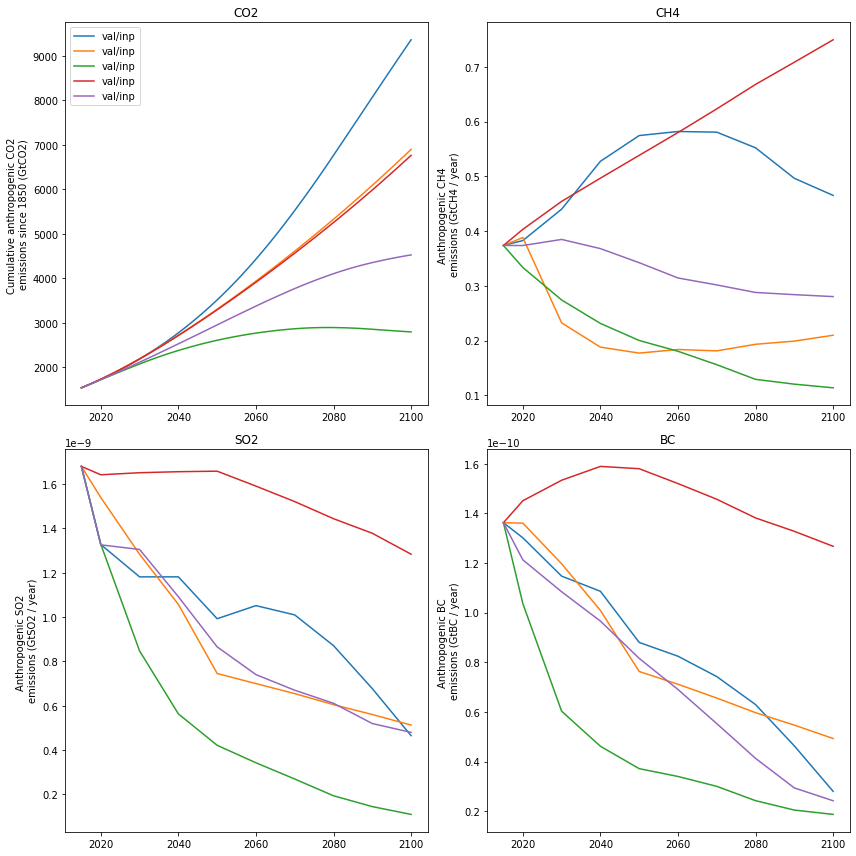

In [20]:
#plot inputs
data_path = "./data/train_val/"
from glob import glob

inputs = glob(data_path + "inputs_s*.nc")
SECONDS_IN_YEAR = 60*60*24*365 #s

fig, axes = plt.subplots(2, 2, figsize=(12,12))

for input in inputs:
    label=input.split('_')[1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)

    weights = np.cos(np.deg2rad(X.latitude))
    
    axes[0, 0].plot(x, X['CO2'].data, label=label)
    axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[0, 1].plot(x, X['CH4'].data, label=label)
    axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
    axes[1, 0].plot(x, X['SO2'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
    axes[1, 1].plot(x, X['BC'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

axes[0, 0].set_title('CO2')
axes[0, 1].set_title('CH4')
axes[1, 0].set_title('SO2')
axes[1, 1].set_title('BC')
axes[0, 0].legend()
plt.tight_layout()

In [5]:
## Set up training data

#adapted from Kai and Theorodore:
def cube_to_vector(data_array):
    "transforms 3 dimensional xarray (time, lat, lon) to 2 dimensional numpy array (time, lat*lon)"
    time_range = data_array["time"].shape[0]
    
    return data_array.values.reshape(time_range, 96 * 144)


def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def create_predictor_data(data_set, n_eofs=5):
    """
    Args:
        data_set (str): name of dataset
        n_eofs (int): number of eofs to create for aerosol variables
    
    """
    X = xr.open_dataset(data_path + "inputs_{}.nc".format(data_set)).compute()
    
    if data_set == "hist-aer":
        X = X.rename_vars({"CO4":"CO2"})
        X = X.sel(time=slice(1850,2100))

    if data_set == "hist-GHG":
        X = X.sel(time=slice(1850,2014))
    
    if "ssp" in data_set or data_set == "hist-aer":
        # Create an EOF solver to do the EOF analysis. Square-root of cosine of
        # latitude weights are applied before the computation of EOFs.
        bc_solver = Eof(X['BC'])

        # Retrieve the leading EOF, expressed as the correlation between the leading
        # PC time series and the input SST anomalies at each grid point, and the
        # leading PC time series itself.
        bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
        bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

        # Create an EOF solver to do the EOF analysis. Square-root of cosine of
        # latitude weights are applied before the computation of EOFs.
        so2_solver = Eof(X['SO2'])

        # Retrieve the leading EOF, expressed as the correlation between the leading
        # PC time series and the input SST anomalies at each grid point, and the
        # leading PC time series itself.
        so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
        so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)

        # Convert the Principle Components of the aerosol emissions (calculated above) in to Pandas DataFrames
        bc_df = bc_pcs.to_dataframe().unstack('mode')
        bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

        so2_df = so2_pcs.to_dataframe().unstack('mode')
        so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]
    else:
        # all values are zero, fill up eofs so we have same inputs as for other datasets
        timesteps = X["time"].shape[0]
        zeros = np.zeros(shape=(timesteps, n_eofs))
        bc_df = pd.DataFrame(zeros, columns=[f"BC_{i}" for i in range(n_eofs)],index=X["BC"].coords['time'].data)
        so2_df = pd.DataFrame(zeros, columns=[f"SO2_{i}" for i in range(n_eofs)],index=X["BC"].coords['time'].data)

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    #5-year running mean of CO2
    co2_1 = normalize_co2(X["CO2"].data)
    co2_5yr=moving_average(co2_1,5)
    nan_array = np.empty((1,4))
    nan_array[:] = np.NaN
    co2_5yr = np.append(nan_array, co2_5yr)
    
    co2_5 = pd.DataFrame({"CO2_5YR": co2_5yr}, index=X["CO2"].coords['time'].data)
    
    # Combine with aerosol EOFs
    inputs=pd.concat([inputs, bc_df, so2_df, co2_5], axis=1)
    
    # replace nan values with 0
    inputs = inputs.replace(np.nan, 0)
    
    return inputs

def create_predicatand_data(data_set):
    Y = xr.open_dataset(data_path + "outputs_{}.nc".format(data_set)).mean("member")
    if data_set == "hist-aer":
        Y = Y.sel(time=slice(1850,2100))
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400
    return Y

def create_predicatand_data(data_set):
    Y = xr.open_dataset(data_path + "outputs_{}.nc".format(data_set)).mean("member")
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400
        
    return Y

files = ["ssp126","ssp585","historical","1pctCO2","hist-GHG","hist-aer"]

# create training data
X_train = pd.concat([create_predictor_data(file) for file in files])
y_train_tas = np.vstack((cube_to_vector(create_predicatand_data(file)["tas"]) for file in files))
# y_train_pr = np.vstack((cube_to_vector(create_predicatand_data(file)["pr"]) for file in files))
y_train_dtf = np.vstack((cube_to_vector(create_predicatand_data(file)["diurnal_temperature_range"]) for file in files))
# y_train_pr90 = np.vstack((cube_to_vector(create_predicatand_data(file)["pr90"]) for file in files)) 

files2 = ["ssp245"]

# create test data
X_test = pd.concat([create_predictor_data(file) for file in files2])
test_Y = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()

tas_truth = test_Y["tas"].mean('member')
pr_truth = test_Y["pr"].mean('member') * 86400
pr90_truth = test_Y["pr90"].mean('member') * 86400
dtr_truth = test_Y["diurnal_temperature_range"].mean('member')

<ipython-input-5-96c202768831>:110: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_train_tas = np.vstack((cube_to_vector(create_predicatand_data(file)["tas"]) for file in files))
<ipython-input-5-96c202768831>:112: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_train_dtf = np.vstack((cube_to_vector(create_predicatand_data(file)["diurnal_temperature_range"]) for file in files))


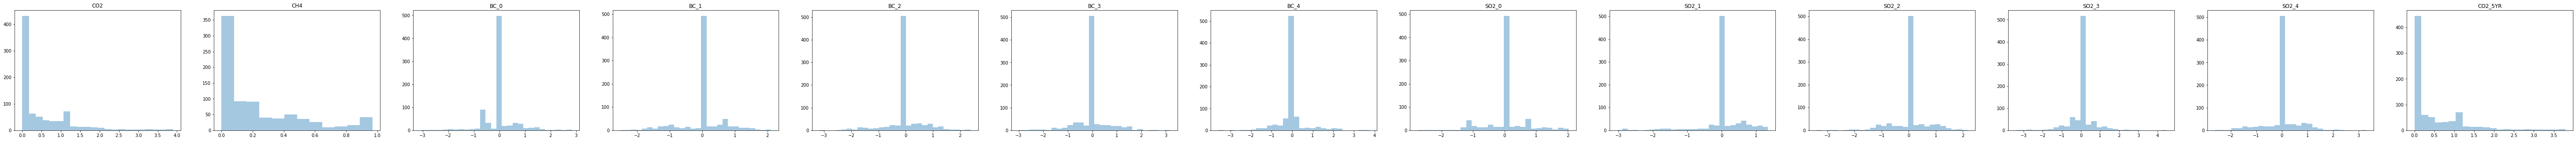

In [12]:
fig, ax = plt.subplots(1, X_train.shape[-1], figsize=(8 * X_train.shape[-1], 5))

for i, col in enumerate(X_train.columns):
    sns.distplot(X_train[col].values.flatten(), kde=False, ax=ax[i])
    ax[i].set_title(col)

In [151]:
# standardize data
standard_X_train = (X_train - X_train.mean()) / X_train.std()
standard_X_test = (X_test - X_train.mean()) / X_train.std()

y_train_tas_mean = y_train_tas.mean()
y_train_tas_std = y_train_tas.std()

log_y_train_dtf = np.log(y_train_dtf)
log_y_train_dtf_mean = log_y_train_dtf.mean()
log_y_train_dtf_std = log_y_train_dtf.std()
y_train_dtf_mean = y_train_dtf.mean()
y_train_dtf_std = y_train_dtf.std()

standard_y_train_tas = (y_train_tas - y_train_tas_mean) / y_train_tas_std
standard_y_train_dtf = (y_train_dtf - y_train_dtf_mean) / y_train_dtf_std
standard_log_y_train_dtf = (log_y_train_dtf - log_y_train_dtf_mean) / log_y_train_dtf_std

<ipython-input-151-e3fe8bbec0e5>:8: RuntimeWarning: invalid value encountered in log
  log_y_train_dtf = np.log(y_train_dtf)


$$
\sigma^2_{CO_2}k_{CO_2} + \sigma^2_{CH_4}k_{CH_4} + \sigma^2_{BC}k_{BC}\left(\frac{BC_i}{\ell_i}\right) + \sigma^2_{SO_2}k_{SO_2}\left(\frac{SO2_i}{\ell_i}\right) + \sigma^2_{CO2_5Y}k_{CO2_5Y}
$$

### Make a kernel
With gpflow, we need to explicitely construct a kernel instance. This is the real strength of gpflow, we can be much finer in our choices of kernels as we have much more flexibility.

- `gpflow.kernels.Linear`
- `gpflow.kernels.Matern12` -> continous functions
- `gpflow.kernels.Matern32` -> differentiable functions
- `gpflow.kernels.RBF` -> infinitely smooth function

In [152]:
kernel_CO2 = gpflow.kernels.Linear(active_dims=[0])
kernel_CH4 = gpflow.kernels.Linear(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Matern32(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

### Make a GP
This is easier than with GPytorch since a GP regression class already exists. We just need to feed it the training data and the kernel.

gpflow takes care for you of modelling each output dimension as an independent GP with shared kernel.

In [153]:
model = gpflow.models.GPR(data=(standard_X_train.astype(np.float64)[:100], 
                                standard_y_train_tas.astype(np.float64)[:100]),
                          kernel=kernel)

In [147]:
# model = gpflow.models.GPR(data=(standard_X_train.astype(np.float64), 
#                                 standard_log_y_train_dtf.astype(np.float64)),
#                           kernel=kernel)

### Train the GP

Unlike pytorch, we don't need to specify the entire training loop here. All we need is to specify which kind of optimization strategy we want to use (here using the default one provided by scipy)

In [154]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

      fun: 800137.4805864561
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.27843020e+000,  3.33031461e-039, -1.37049552e-004,
        1.65028776e+000, -1.61188726e-002,  2.22919200e-001,
        1.90433205e-001, -4.83609494e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000, -5.52748220e-131, -2.50207311e-001,
        2.38177253e+000, -1.34573891e+001])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 186
      nit: 155
   status: 0
  success: True
        x: array([-1.22466587e+00, -9.69916216e+01,  4.42519969e+02, -1.32804177e-02,
        3.32190029e+00, -1.44045942e+00,  3.74134773e+00, -3.07776528e+00,
       -3.21695775e-01, -1.82182435e+01, -6.88801735e+01,  4.14779267e+01,
        1.26886820e+01, -3.04603155e+02,  1.25462479e+01, -9.19169636e-01,
       -1.94050288e+00])

### Run prediction

In [155]:
standard_mod_tas = model.predict_y(standard_X_test.values)[0]
mod_tas = standard_mod_tas * y_train_tas_std + y_train_tas_mean

# standard_mod_dtf = model.predict_y(standard_X_test.values)[0]
# mod_dtf = standard_mod_dtf * y_train_dtf_std + y_train_dtf_mean

# standard_mod_logdtf = model.predict_y(standard_X_test.values)[0]
# mod_dtf = np.exp(standard_mod_logdtf * log_y_train_dtf_std + log_y_train_dtf_mean)

In [156]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
m_tas = np.reshape(mod_tas, [86, 96, 144])
m_tas_data = xr.DataArray(m_tas, dims = tas_truth.dims)

# m_dtf = np.reshape(mod_dtf, [86, 96, 144])
# m_dtf_data = xr.DataArray(m_dtf, dims = dtr_truth.dims)

In [157]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

print(f"RMSE at 2015: {get_rmse(tas_truth[0], m_tas_data[0])}")
print(f"RMSE at 2050: {get_rmse(tas_truth[35], m_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], m_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:40], m_tas_data[30:40]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], m_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], m_tas_data[35:]).mean()}")



# def get_rmse(truth, pred):
#     weights = np.cos(np.deg2rad(truth.lat))
#     return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# print(f"RMSE at 2015: {get_rmse(dtr_truth[0], m_dtf_data[0])}")
# print(f"RMSE at 2050: {get_rmse(dtr_truth[35], m_dtf_data[35])}")
# print(f"RMSE at 2100: {get_rmse(dtr_truth[85], m_dtf_data[85])}")
# print(f"RMSE 2045-2055: {get_rmse(dtr_truth[30:40], m_dtf_data[30:40]).mean()}")
# print(f"RMSE 2090-2100: {get_rmse(dtr_truth[75:], m_dtf_data[75:]).mean()}")
# print(f"RMSE 2050-2100: {get_rmse(dtr_truth[35:], m_dtf_data[35:]).mean()}")

RMSE at 2015: 0.37149180638079593
RMSE at 2050: 0.4009226182640929
RMSE at 2100: 0.640583688678027
RMSE 2045-2055: 0.41458480798003494
RMSE 2090-2100: 0.6829290692816129
RMSE 2050-2100: 0.5876737678194872


In [160]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.2576268057068985
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,7.5348381599043e-43
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.04503271156335908
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[4.42519969e+02, 6.86529018e-01, 3.35734870e+00..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,5.158585886789278e-133
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[5.45179916e-01, 1.22438325e-08, 1.21820597e-30..."
GPR.kernel.kernels[4].variance,Parameter,Softplus,,True,(),float64,0.3356505380921814
GPR.kernel.kernels[4].lengthscales,Parameter,Softplus,,True,(),float64,12.546251481031737
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.13420990301314148


In [119]:
model.kernel.kernels[3].lengthscales

<Parameter: dtype=float64, shape=[5], fn="softplus", numpy=array([ 0.55972978,  0.21374131,  1.16799377, 62.72003225,  1.08878331])>